In [1]:
import sys
sys.path.append("/media/wdp/disk4/git/noiseba/src")  # 添加 src 到模块搜索路径

import numpy as np
import matplotlib.pyplot as plt

from disba import PhaseDispersion

from noiseba.inversion import Curve, Model, CostFunction, Inversion


from noiseba.utils import plot_phase_velocity_curves, plot_velocity_profile
from noiseba.optimization import PSO

## Synthetic dispersion curves

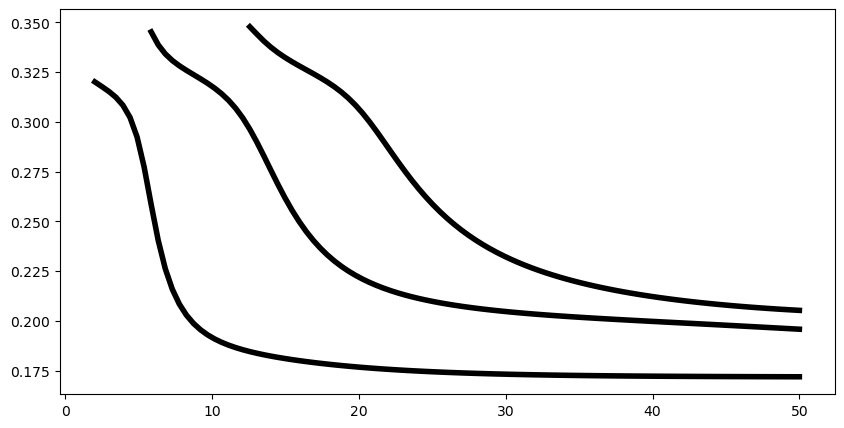

In [2]:
# thickness(km), vp(km/s), vs, rho in sequence
velocity_model = np.array([
   [0.005, 1.50, 0.18, 1.78],
   [0.01,  1.60, 0.20, 1.80],
   [0.05,  1.70, 0.35, 1.85],
])

# frequencies
fdisp = np.linspace(2, 50, 101)

# Periods (must be sorted starting with low periods)
period = np.flipud(1/fdisp)
pd = PhaseDispersion(*velocity_model.T)
cpr = [pd(period, mode=i, wave="rayleigh") for i in range(3)]

plt.figure(figsize=(10, 5))
for imode in range(3):
    plt.plot(np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), 'k', lw=4,)

## Define survey

In [3]:
# Store the observed curves
curves = [Curve(freq=np.flipud(1 / cpr[0].period), velocity=np.flipud(cpr[0].velocity), wave_type='rayleigh', mode=0,),
           Curve(freq=np.flipud(1 / cpr[1].period), velocity=np.flipud(cpr[1].velocity), wave_type='rayleigh', mode=1)]

In [ ]:
# site_cos = dict(site0=CostFunction(curves, alpha=0, weights=np.array([1, 1])), 
#                     site1=CostFunction(curves, alpha=0, weights=np.array([1, 1])))

## Define initial model and optimization parameters
- In practice, we only invert the parameters of vs and thickness, as they exhibit greater sensitivity to the dispersion curves.. Hence, vp and density are inferred from the above two parameters

In [ ]:
# bounds [thick_low, thick_high, vs_low, vs_high]
vs_thick_bounds = np.array([[0.003, 0.008, 0.15, 0.20],
                            [0.005, 0.025, 0.15, 0.25],
                            [0.02,  0.060,  0.30, 0.40]])

# define initial model
model = Model(vs_thick_bounds)

# define cost function
# alpha contral the weight of smoothness term, weights control the weight of each dispersion curves
# cos = CostFunction(curves, alpha=0, weights=np.array([1, 1]))

# define optimizer
opt = PSO
directives = {
    "population_size" : 20,
    "max_iterations" : 300,
    'c1': 2.1,
    'c2': 2.1,
    'njobs': 1,
    'rng_seed': None
}


inv = Inversion(cos, opt, directives)

## Run the inversion

In [6]:
inv.run(model)

PSO Optimizing: 100%|██████████| 300/300 , misfit=1.770457e-07
PSO Optimizing: 100%|██████████| 300/300 , misfit=1.728271e-07


## Compare the synthetic data with the inversion results

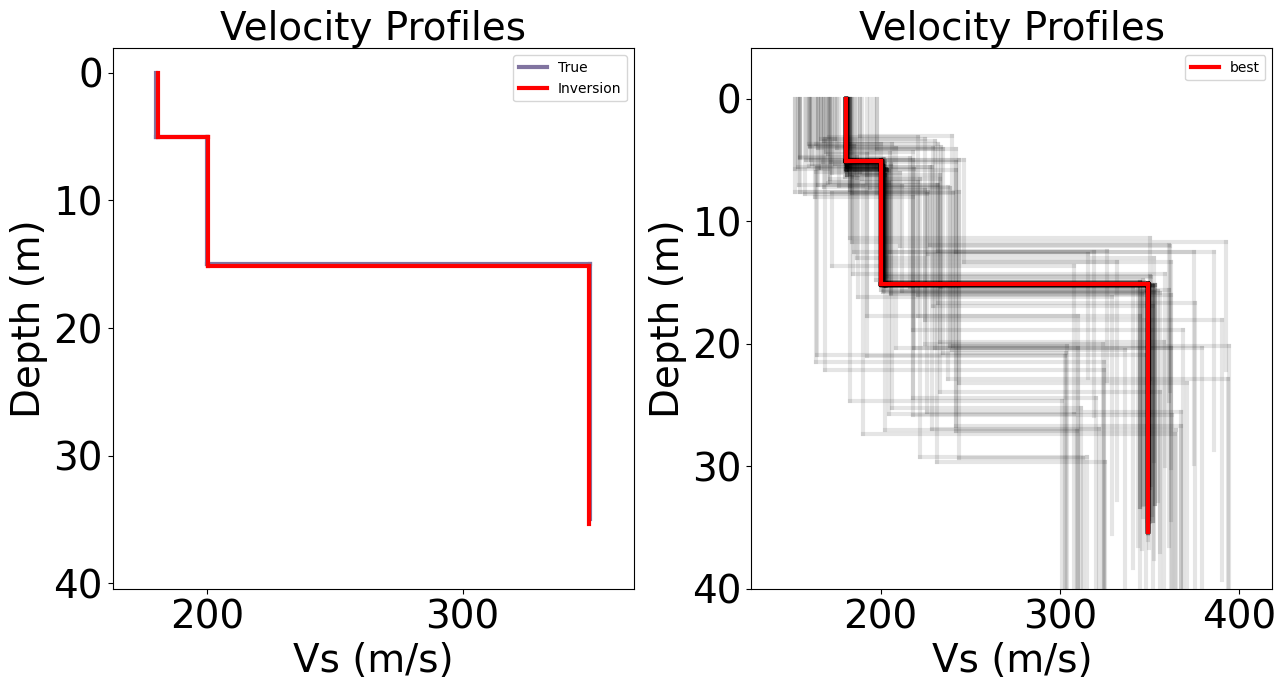

In [7]:
# True model
vel = velocity_model[:,2]
thick = velocity_model[:,0]

# Inverted model
k = vs_thick_bounds.shape[0]

vel_inv = inv.best_position()[k:]
thick_inv = inv.best_position()[:k]

# Filtered history model
filter_position = inv.history_positions(threshold=1e-3)
filter_vel = filter_position[:, k:][::30] # step size
filter_thick = filter_position[:, :k][::30]



fig, ax = plt.subplots(1, 2, figsize=(13,7))

plot_velocity_profile(vel ,thick, unit='m', axes=ax[0], plot_kwargs={'label': 'True'})
plot_velocity_profile(vel_inv ,thick_inv, unit='m', axes=ax[0], plot_kwargs={'color': 'r', 'label': 'Inversion'})

plot_velocity_profile(filter_vel, filter_thick, unit='m', axes=ax[1], plot_kwargs={'color': 'k', 'alpha': 0.1,})
plot_velocity_profile(vel_inv ,thick_inv, unit='m', axes=ax[1], plot_kwargs={'color': 'r', 'label': 'best'})

ax[0].invert_yaxis()
ax[0].legend()

ax[1].invert_yaxis()
ax[1].legend()
ax[1].set_ylim(bottom=40)

plt.tight_layout()

In [59]:
filter_curve = inv.history_curves(threshold=1e-5)

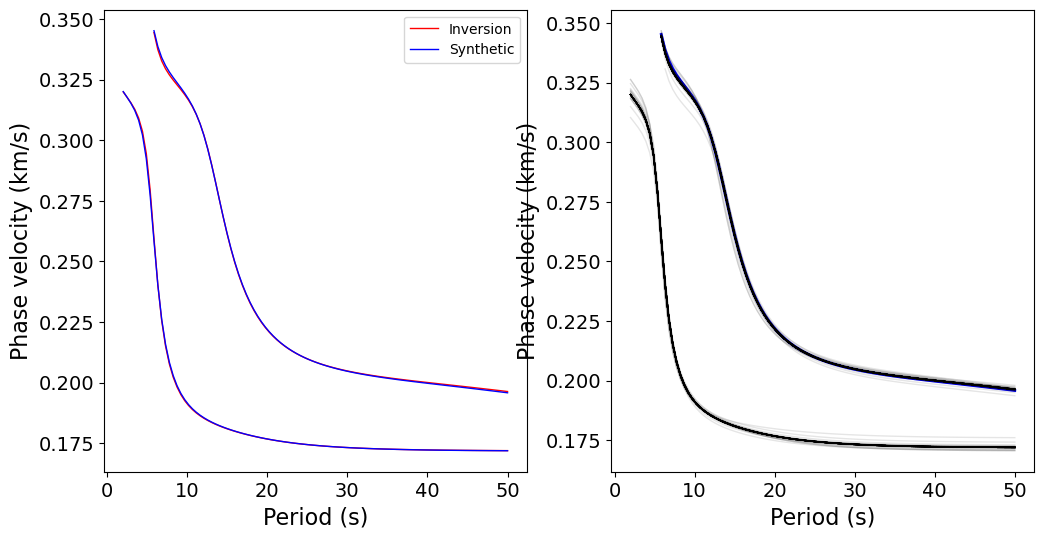

In [60]:
inv_curves_m0 = inv.best_curves().get('mode0')
inv_curves_m1 = inv.best_curves().get('mode1')
synthetic_curves = inv.result['site0']['obs_curves']


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_phase_velocity_curves(inv_curves_m0[0].freq, inv_curves_m0[0].velocity, axes=ax[0], plot_kwargs={'color': 'r', 'label': 'Inversion'})
plot_phase_velocity_curves(inv_curves_m1[0].freq, inv_curves_m1[0].velocity, axes=ax[0], plot_kwargs={'color': 'r'})

plot_phase_velocity_curves(synthetic_curves[0].freq, synthetic_curves[0].velocity, axes=ax[0], plot_kwargs={'color': 'b', 'label': 'Synthetic'})
plot_phase_velocity_curves(synthetic_curves[1].freq, synthetic_curves[1].velocity, axes=ax[0], plot_kwargs={'color': 'b'})

ax[0].legend()


plot_phase_velocity_curves(synthetic_curves[1].freq, synthetic_curves[1].velocity, axes=ax[1], plot_kwargs={'color': 'b', 'lw': 2})
for key in filter_curve.keys():
    for cur in filter_curve[key][::30]:
        freq = cur.freq
        vel = cur.velocity
        plot_phase_velocity_curves(freq, vel, axes=ax[1], plot_kwargs={'color': 'k', 'alpha':0.1})


